# Pre-processing notebook

In this notebook, we will pre-process the frames. For better visualisation, we will just capture 2 frames and visualise all the steps. The steps are:
1. Capture 2 consecutive frames. 
2. Find difference between the frames to capture the motion.
3. Use GaussianBlur, thresholding, dilation and erosion to pre-process the frames.
4. Image segmentation using contours. Extract the vehicles during this method.
5. Convert contours to hulls. 

In [1]:
# Run these if OpenCV doesn't load

import sys
# sys.path.append('/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/cv2/')

First, we import the necessary libraries

In [2]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline 

Next, we define variables that will be used through the duration of the code

In [3]:
# Here, we define some colours
SCALAR_BLACK = (0.0,0.0,0.0)
SCALAR_WHITE = (255.0,255.0,255.0)
SCALAR_YELLOW = (0.0,255.0,255.0)
SCALAR_GREEN = (0.0,255.0,0.0)
SCALAR_RED = (0.0,0.0,255.0)
SCALAR_CYAN = (255.0,255.0,0.0)

Function to draw the image

In [4]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image,caption in zip(axes, images, captions):
        ax.imshow(image, cmap)
        ax.set_title(caption)

### Capturing movement in video
**Two consecutive frames are required to capture the movement**. If there is movement in vehicle, there will be small change in pixel value in the current frame compared to the previous frame. The change implies movement. Let's capture the first 2 frames now.

img1 height720
img1 width1280
img2 height720
img2 width1280


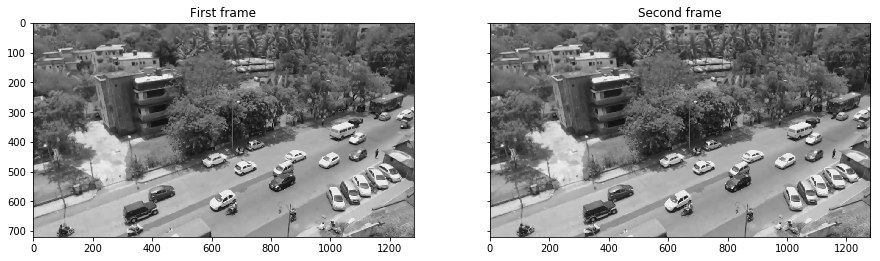

In [5]:
SHOW_DEBUG_STEPS  = True

# Reading video 
cap = cv2.VideoCapture('../AundhBridge.mp4')

# if video is not present, show error
if not(cap.isOpened()):
    print("Error reading file")

# Check if you are able to capture the video    
ret, fFrame  = cap.read()

# Capturing 2 consecutive frames and making a copy of those frame. Perform all operations on the copy frame. 
ret, fFrame1 = cap.read()
ret, fFrame2 = cap.read()
img1 = fFrame1.copy()
img2 = fFrame2.copy()

if(SHOW_DEBUG_STEPS):
    print ('img1 height' + str(img1.shape[0]))
    print ('img1 width' + str(img1.shape[1]))
    print ('img2 height' + str(img2.shape[0]))
    print ('img2 width' + str(img2.shape[1]))

# Convert the colour images to greyscale in order to enable fast processing    
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#plotting
plot_image([img1, img2], cmap='gray', captions=["First frame", "Second frame"])

### Adding gaussion blur for smoothening

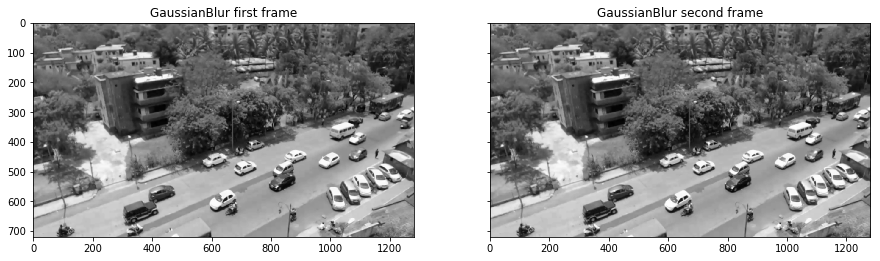

In [6]:
# Add some Gaussian Blur
img1 = cv2.GaussianBlur(img1,(5,5),0)
img2 = cv2.GaussianBlur(img2,(5,5),0)

#plotting
plot_image([img1, img2], cmap='gray', captions=["GaussianBlur first frame", "GaussianBlur second frame"])

### Find the movement in video
If vehicle is moving, there will be **slight change** in pixel value in the next frame compared to previous frame. We then threshold the image. This will be useful further for preprocessing. Pixel value below 30 will be set as 0(black) and above as 255(white)

Thresholding: https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html

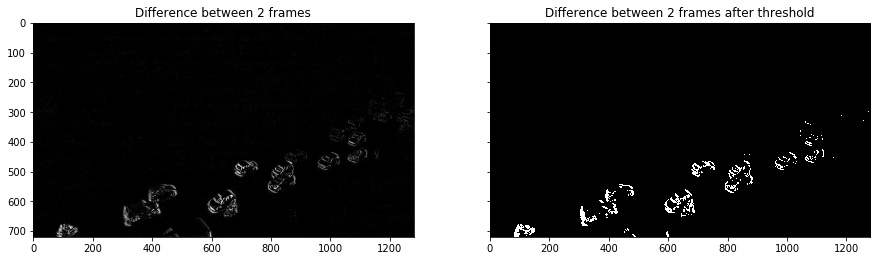

In [7]:
# This imgDiff variable is the difference between consecutive frames, which is equivalent to detecting movement
imgDiff = cv2.absdiff(img1, img2) 

# Thresholding the image that is obtained after taking difference. Pixel value below 30 will be set as 0(black) and above as 255(white)
ret,imgThresh = cv2.threshold(imgDiff,30.0,255.0,cv2.THRESH_BINARY)
ht = np.size(imgThresh,0)
wd = np.size(imgThresh,1)
plot_image([imgDiff, imgThresh], cmap='gray', captions = ["Difference between 2 frames", "Difference between 2 frames after threshold"])

### Dilation and erosion in image 
Dilation and erosion in the image with the filter size of structuring elements.

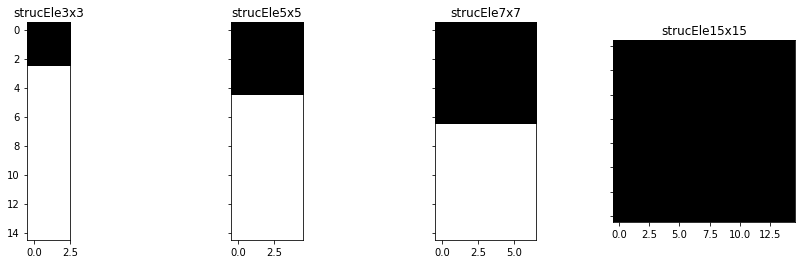

In [8]:
# Now, we define structuring elements

strucEle3x3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
strucEle5x5 = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
strucEle7x7 = cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))        
strucEle15x15 = cv2.getStructuringElement(cv2.MORPH_RECT,(15,15))

plot_image([strucEle3x3, strucEle5x5, strucEle7x7, strucEle15x15], cmap='gray', captions = ["strucEle3x3", "strucEle5x5", "strucEle7x7", "strucEle15x15"])


imgThreshCopy height720
imgThreshCopy width1280
imgThreshCopy height720
imgThreshCopy width1280


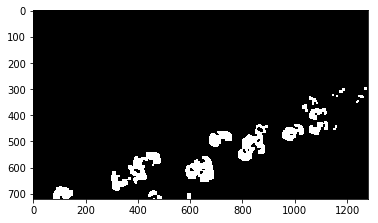

In [9]:
for i in range(2):
    imgThresh = cv2.dilate(imgThresh,strucEle5x5,iterations = 2)
    imgThresh = cv2.erode(imgThresh,strucEle5x5,iterations = 1)

    imgThreshCopy = imgThresh.copy()
    if(SHOW_DEBUG_STEPS):        
        print ('imgThreshCopy height' + str(imgThreshCopy.shape[0]))
        print ('imgThreshCopy width' + str(imgThreshCopy.shape[1]))
        
plt.imshow(imgThresh, cmap = 'gray')        

## Extracting contours
Till now, you have a binary image. Next, we will segment the image and find all possible contours(possible vehicles). The shape of the contours will tell us the number of contours that has been identified. Define *drawAndShowContours()* function to plot the contours. You will see that the threshold image above and the countour image will look alike. So, additionally, we also plot a particular '9th' countour for further clarity. 

In [10]:
def drawAndShowContours(wd,ht,contours,strImgName):
    global SCALAR_WHITE
    global SHOW_DEBUG_STEPS
    
    # Defining a blank frame. Since it is initialised with zeros, it will be black. Will add all the coutours in this image.
    blank_image = np.zeros((ht,wd,3), np.uint8)
    #cv2.drawContours(blank_image,contours,10,SCALAR_WHITE,-1)
    
    # Adding all possible contour to the blank frame. Contour is white 
    cv2.drawContours(blank_image,contours,-1,SCALAR_WHITE,-1)
    
    
    # For better clarity, lets just view countour 9
    blank_image_contour_9 = np.zeros((ht,wd,3), np.uint8)
    
    # Let's just add contour 9 to the blank image and view it
    cv2.drawContours(blank_image_contour_9,contours,8,SCALAR_WHITE,-1)
    
    # Plotting
    plot_image([blank_image, blank_image_contour_9], cmap='gray', captions = ["All possible contours", "Only the 9th contour"])

        
    return blank_image

contours.shape: 22


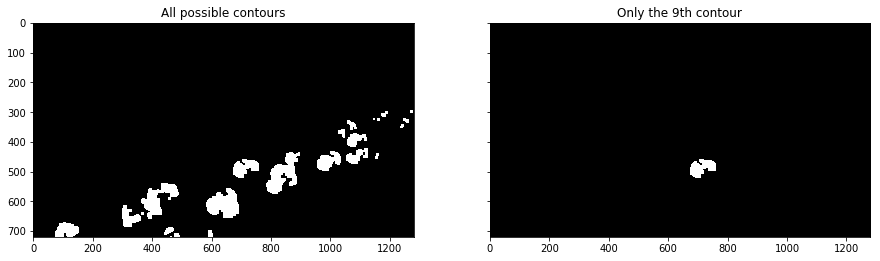

In [11]:
# Now, we move on to the contour mapping portion    
        
im, contours, hierarchy = cv2.findContours(imgThreshCopy,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
im2 = drawAndShowContours(wd,ht,contours,'imgContours')

# Printing all the coutours in the image.
if(SHOW_DEBUG_STEPS):
    print ('contours.shape: ' + str(len(contours)))

## Hulls
Hulls are contours with the "convexHull".

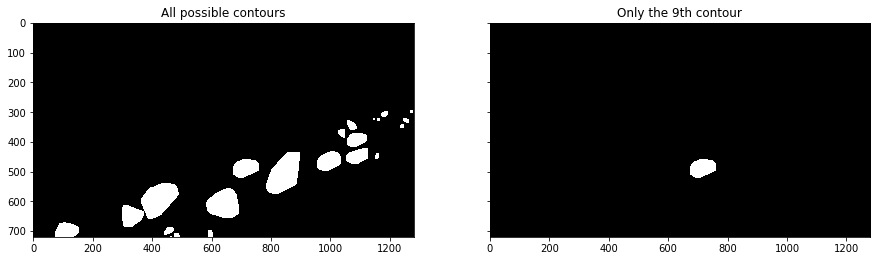

In [12]:
# Next, we define hulls.
# Hulls are contours with the "convexHull" function from cv2

hulls = contours # does it work?
for i in range(len(contours)):
    hulls[i] = cv2.convexHull(contours[i])

# Then we draw the contours    
im3 = drawAndShowContours(wd,ht,hulls,'imgConvexHulls')